# Generate plots for figure 4

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from definitions import ROOT_DIR, NUM_MUSCLES, NUM_JOINTS
from helpers import get_pos_vel_act, average_by_timestep
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

## Load the performance decay dataset and plot it

In [12]:
# make folders for figure if they don't already exist
out_path = os.path.join(ROOT_DIR, "data", "figures", "fig_4")
os.makedirs(out_path, exist_ok=True)

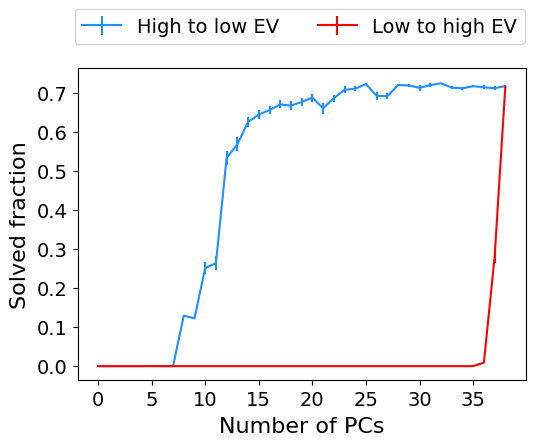

In [13]:
sorting_modes = ["best_to_worst", "worst_to_best"]

perf_dict = {
        mode: pickle.load(open(os.path.join(ROOT_DIR, "data", "datasets", "csi", f"performance_action_components_baoding_{mode}.pkl"),'rb')) for mode in sorting_modes
    }

label_dict = {
    "best_to_worst": "High to low EV",
    "worst_to_best": "Low to high EV",
}
color_list = ["dodgerblue", "red"]
plt.figure()
for (mode, performance_components), color in zip(perf_dict.items(), color_list):
    perfs_mean = np.array([d['solved_frac_mean'] for d in performance_components[::-1]])
    perfs_sem = np.array([d['solved_frac_sem'] for d in performance_components[::-1]])

    plt.errorbar(np.arange(NUM_MUSCLES), perfs_mean, yerr=perfs_sem, fmt='-', label=label_dict[mode], color=color)
    plt.xlabel('Number of PCs',fontsize=16,labelpad=5)
    plt.ylabel('Solved fraction',fontsize=16,labelpad=5)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.subplots_adjust(left=0.2,bottom=0.23)
plt.legend(bbox_to_anchor=(1.02, 1.22), fontsize=14, ncol=2)
plt.savefig(os.path.join(out_path, "pca_performance_contrib.png"), format="png", dpi=600, bbox_inches="tight")
plt.show()

## Load the dataset Baoding-SV and Control

In [10]:
baoding_df = pd.read_hdf(os.path.join(ROOT_DIR, "data", "datasets", "rollouts", "baoding_sv_no_activity.h5"))
control_df = pd.read_hdf(os.path.join(ROOT_DIR, "data", "datasets", "rollouts", "hand_pose.h5"))

pos_control, vel_control, muscle_act_control = get_pos_vel_act(control_df)
pos_baoding, vel_baoding, muscle_act_baoding = get_pos_vel_act(baoding_df)

## Plot the active muscles as a function of the activity threshold

In [11]:
min_val = min(np.min(muscle_act_baoding), np.min(muscle_act_control))
max_val = max(np.max(muscle_act_baoding), np.max(muscle_act_control))
eps = 1e-6
threshold_vec = np.linspace(min_val - eps, max_val - eps, 1000)

active_baoding_list = []
active_baoding_sem_list = []
active_control_list = []
active_control_sem_list = []
for threshold in threshold_vec:
    muscle_act_baoding_bin = (muscle_act_baoding > threshold).astype(int).sum(axis=1)
    muscle_act_control_bin = (muscle_act_control > threshold).astype(int).sum(axis=1)
    avg_active_muscles_baoding = np.mean(muscle_act_baoding_bin)
    sem_active_muscles_baoding = np.std(muscle_act_baoding_bin) / np.sqrt(len(muscle_act_baoding_bin))
    avg_active_muscles_control = np.mean(muscle_act_control_bin)
    sem_active_muscles_control = np.std(muscle_act_control_bin) / np.sqrt(len(muscle_act_control_bin))
    active_baoding_list.append(avg_active_muscles_baoding)
    active_baoding_sem_list.append(sem_active_muscles_baoding)
    active_control_list.append(avg_active_muscles_control)
    active_control_sem_list.append(sem_active_muscles_control)


/tmp/ipykernel_31737/2027579811.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


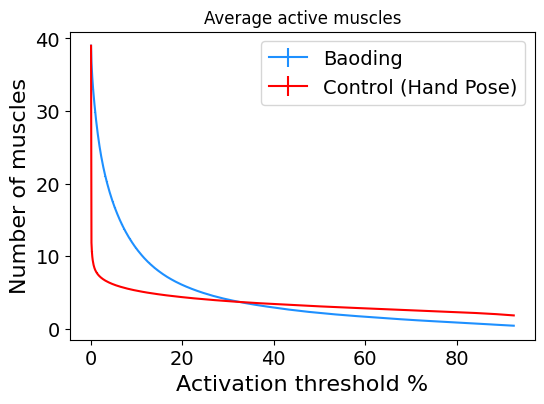

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
threshold_vec_pct = threshold_vec * 100
ax.errorbar(threshold_vec_pct, active_baoding_list, yerr=active_baoding_sem_list, fmt='-', label="Baoding", color="dodgerblue")
ax.errorbar(threshold_vec_pct, active_control_list, yerr=active_control_sem_list, fmt='-', label="Control (Hand Pose)", color="red")

ax.set_title("Average active muscles")
ax.set_xlabel("Activation threshold %", fontsize=16)
ax.set_ylabel("Number of muscles", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.legend(fontsize=14)
fig.savefig(os.path.join(out_path, f"activation_vs_threshold.png"), format="png", dpi=600, bbox_inches="tight")
fig.show()

In [15]:
# For the text: number of muscles active at 5%
idx = sum(threshold_vec < 0.05)
print("Control: ", active_control_list[idx])
print("Baoding: ", active_baoding_list[idx])

Control:  6.06472
Baoding:  17.012291294127103


## Plot time series of hand pose projected onto different PC ranges

/tmp/ipykernel_31737/485303195.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


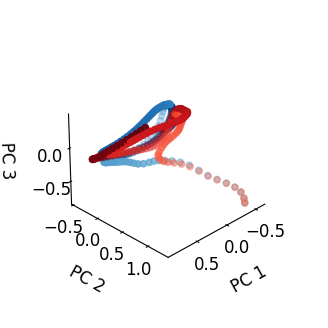

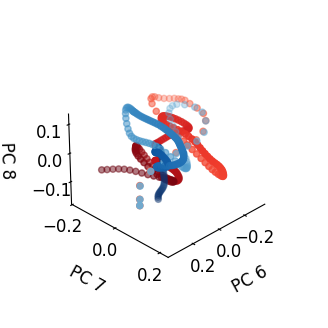

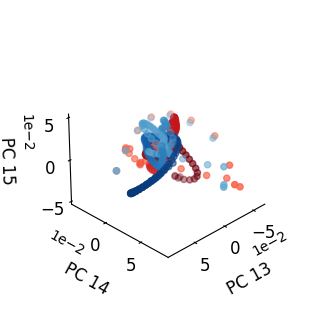

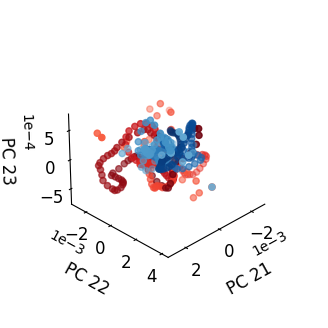

In [16]:
# PCA plots of different component ranges
data = np.vstack(baoding_df.observation)[:, :NUM_JOINTS]

pc_range_list = [(0, 3), (5, 8), (12, 15), (20, 23)]
cmap_list = ["Reds", "Blues"]
dir_list = ["cw", "ccw"]
label_list = ["Clockwise", "Counter-clockwise"]
data_name = "joint_pos"

pca = PCA(n_components=data.shape[1])
out = pca.fit_transform(data)

for pc_range in pc_range_list:
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(projection="3d")

    for cmap_name, direction, label in zip(cmap_list, dir_list, label_list):
        out_direction = out[baoding_df.task == direction]
        cmap = matplotlib.colormaps[cmap_name]
        color_list = [cmap(i) for i in np.linspace(0.5, 1, 200)]    
        colors = [color_list[idx] for idx in baoding_df.step[baoding_df.task == direction]]
        plot_mat = out_direction[:, pc_range[0]:pc_range[1]]
        mean_traj = average_by_timestep(plot_mat, baoding_df.step[baoding_df.task == direction])
        ax.scatter(mean_traj[:, 0], mean_traj[:, 1], mean_traj[:, 2], c=color_list, label=label)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.view_init(30, 45)
    ax.set_xlabel(f"\n\nPC {pc_range[0] + 1}", fontsize=12)
    ax.set_ylabel(f"\n\nPC {pc_range[0] + 2}", fontsize=12)
    ax.set_zlabel(f"\n\nPC {pc_range[0] + 3}", fontsize=12)
    ax.set_box_aspect(aspect=None, zoom=0.7)
    ax.ticklabel_format(style="sci", scilimits=(-2, 2))
    ax.locator_params(axis='both', nbins=4)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    # ax.legend()
    out_name = f"pca_{data_name}_components_{'_'.join(str(el) for el in pc_range)}.png"
    fig.savefig(os.path.join(out_path, out_name), format="png", dpi=800, bbox_inches="tight")
    fig.show()

In [17]:
# Set numpy random seed
np.random.seed(42)

# Task decoding from the pca trajectories
num_episodes_per_direction = 500
max_episode_len = 200
pos = np.vstack(baoding_df.observation)[:, :NUM_JOINTS]

pc_range_list = [(0, 3), (5, 8), (12, 15), (20, 23)]
pc_range_span = 3
dir_list = ["cw", "ccw"]

pca = PCA(n_components=data.shape[1], random_state=42)
out = pca.fit_transform(data)

for pc_range in pc_range_list:
    X = np.zeros((num_episodes_per_direction * len(dir_list), max_episode_len * pc_range_span))
    y = np.zeros(num_episodes_per_direction * len(dir_list))
    for dir_idx, dir in enumerate(dir_list):
        for ep_id in range(num_episodes_per_direction):
            step_idx_mask = (baoding_df.episode == ep_id) & (baoding_df.task == dir)
            row = out[step_idx_mask, pc_range[0]: pc_range[1]].flatten()
            X[ep_id + dir_idx * num_episodes_per_direction, : len(row)] = row
            y[ep_id + dir_idx * num_episodes_per_direction] = dir_idx
    X = X[:, ~np.all(X[1:] == X[:-1], axis=0)]  # drop constant columns
    
    classification = LogisticRegression(random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = cross_val_score(classification, X, y, cv=cv)

    print(data_name, ", PC range:", pc_range, ", score:", cv_score, ", avg score:", np.mean(cv_score))

joint_pos , PC range: (0, 3) , score: [1. 1. 1. 1. 1.] , avg score: 1.0
joint_pos , PC range: (5, 8) , score: [1. 1. 1. 1. 1.] , avg score: 1.0
joint_pos , PC range: (12, 15) , score: [1.    0.995 0.995 0.995 1.   ] , avg score: 0.9970000000000001
joint_pos , PC range: (20, 23) , score: [1.    0.93  0.995 0.83  1.   ] , avg score: 0.9510000000000002
